# CICERO SCM notebook example - interactive input

Import some stuff

In [2]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Import the model

In [3]:
sys.path.insert(0, os.path.join(os.getcwd(), "../", "src"))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [4]:
from ciceroscm.input_handler import (
    read_inputfile,
    read_components,
    read_natural_emissions,
)

Define a function to convert model output to a dataframe

In [5]:
def to_df(cscm):
    out = pd.concat(
        [pd.DataFrame(v) for k, v in cscm.results.items()],
        axis=1,
        keys=list(cscm.results.keys()),
    )
    return out

set up input directories

In [6]:
test_data_dir = os.path.join(os.getcwd(), "../", "tests", "test-data")

# Read in datafiles into dataframes

In [7]:
# NBVAL_IGNORE_OUTPUT
# Read gas parameters
gaspam = read_components(test_data_dir + "/gases_v1RCMIP.txt")
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [8]:
target_year = 10000

def extend_df_to_year(df, target_year):
    # Get current years
    current_years = df.index
    last_year = current_years[-1]
    # Create new years to add
    new_years = np.arange(last_year + 1, target_year + 1)
    # Repeat last row for each new year
    if len(new_years) > 0:
        last_row = df.loc[[last_year]].copy()
        repeated = pd.concat([last_row]*len(new_years), ignore_index=True)
        repeated.index = new_years
        df = pd.concat([df, repeated])
    return df

In [9]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 = read_natural_emissions(test_data_dir + "/natemis_ch4.txt", "CH4")
df_nat_n2o = read_natural_emissions(test_data_dir + "/natemis_n2o.txt", "N2O")
df_nat_ch4.tail()

,CH4
year,
2496,249.2991
2497,249.2936
2498,249.2909
2499,249.2910
2500,249.3004


In [10]:
df_nat_ch4 = extend_df_to_year(df_nat_ch4, target_year)
df_nat_n2o = extend_df_to_year(df_nat_n2o, target_year)


Read forcing

In [11]:
df_ssp2_conc = read_inputfile(test_data_dir + "/ssp245_conc_RCMIP.txt")
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [12]:
df_ssp2_conc = extend_df_to_year(df_ssp2_conc, target_year)

In [13]:
df_a4x_conc=df_ssp2_conc.copy()


In [14]:
df_a4x_conc.iloc[:, :] = df_ssp2_conc.iloc[0, :].values
df_a4x_conc.iloc[200:, 0] = df_ssp2_conc.iloc[0, 0] * (1.01 ** (np.arange(0, len(df_ssp2_conc.iloc[200:, 0].values))))
df_a4x_conc.iloc[350:, 0] = df_ssp2_conc.iloc[0, 0] * (1.01 ** 150)

df_a4x_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
1700,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.746,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


<Axes: >

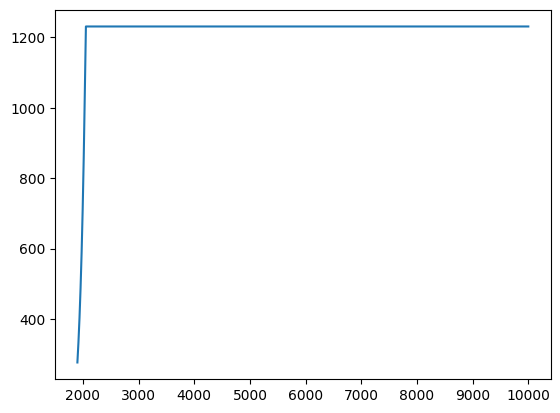

In [15]:
df_a4x_conc.iloc[200:, 0].plot()

In [16]:
df_a4x_conc= extend_df_to_year(df_a4x_conc, target_year)
df_a4x_conc.tail()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
9996,1231.083241,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
9997,1231.083241,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
9998,1231.083241,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
9999,1231.083241,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
10000,1231.083241,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [17]:
emi_input = read_inputfile(test_data_dir + "/ssp245_em_RCMIP.txt")
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)


In [18]:
emi_input.iloc[:, :] = emi_input.iloc[0, :].values
emi_input.head()


,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399
1751,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399
1752,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399
1753,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399
1754,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399


In [19]:
emi_input = extend_df_to_year(emi_input, target_year)
emi_input.tail()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
9996,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399
9997,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399
9998,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399
9999,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399
10000,0.002592,0.081127,19.019783,0.05471,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.92769,1.35325,12.520269,0.74452,2.927399


# Set up model run with defined input variables

In [20]:
# NBVAL_IGNORE_OUTPUT
scen = "test"
cscm_dir = CICEROSCM(
    {
        "gaspam_data": gaspam,
        "emstart": 1750,
        "conc_run": True,
        "nystart": 1750,
        "nyend": target_year,
        "concentrations_data": df_a4x_conc,
        "emissions_data": emi_input,
        "nat_ch4_data": df_nat_ch4,
        "nat_n2o_data": df_nat_n2o,
        "idtm": 24,
        "carbon_cycle_model": "box",
        "thermal_model": "default",
        "sunvolc":0,
    }
)

Carbon Model=box


and run it!

In [21]:
# Using the default of 40 layers (lm=40)

# High resolution for the top 200m
dz_list = [20, 20, 30, 30, 50, 50] 

# Medium resolution for the main thermocline
dz_list += [25] * 39 

# Coarse resolution for the deep and abyssal ocean
dz_list += [150] * 10 
dz_list += [250] * 16 

# NBVAL_IGNORE_OUTPUT
cscm_dir._run(
    {"results_as_dict": True},
    
    pamset_udm={
        "threstemp": 50.0,  # scales vertical velocity as a function of mixed layer temperature
        "rlamdo": 16.0,  # air-sea heat exchange coefficient (wm^-2K^-1)
        "akapa": 0.634,  # vertical heat diffusivity
        "cpi": 0.4,  # temperature change ratio: polar to nonpolar region
        "W": 4,  # vertical velocity (m/yr)
        "beto": 3.5,  # ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
        "lambda": 3.74 / 3,
        "mixed": 60.0,  # mixed layer depth
        "foan": 0.61,  # fraction of northern hemisphere covered by ocean
        "foas": 0.81,  # fraction of northern hemisphere covered by ocean
        "ebbeta": 0.0,  # atmospheric interhemispheric heat exchange
        "fnso": 0.7531,  # ocean area ratio, northern to southern hemisphere
        "lm": 40,  # number of vertical layers
        "ldtime": 12,
        "dz_vector": dz_list,  # layer thicknesses in meters
        "ocean_efficacy": 1.0,  # Ocean efficacy factor
        "amoc_sigmoid_width": 2.0,  # width of sigmoid transition for AMOC
        "amoc_temp_mode": "sigmoid",  # "sigmoid" or "linear" for temperature dependence
  
    },
    pamset_emiconc={
        "lamb": 0.8,
        "qbmb": 0.03,
        "qo3": 0.4,
        "qdirso2": -0.457,
        "qindso2": -0.514,
        "qbc": 0.2,
        "qh2o_ch4": 0.171,
        "qoc": -0.103,
        "ref_yr": 2010,
        "idtm": 24,
            # Box carbon cycle model parameters
        "permafrost_initial_carbon": 500.0,         # PgC
        "permafrost_temp_sensitivity": 0.05,        # PgC/K
        "permafrost_release_delay": 50.0,           # years
        "ocean_exchange_rate": 0.01,                # 1/yr
        "ocean_mixed_layer_depth": 25.0,            # m
        "ocean_solubility_base": 0.02,              # arbitrary units
        "ocean_solubility_temp_coeff": -0.01,       # 1/K
        "vegetation_to_soil_fraction": 0.1,         # fraction/yr
        "soil_respiration_rate": 0.02,              # 1/yr
        "beta_f": 0.287,                            # NPP CO2 fertilization factor
        "land_temp_sensitivity": 0.1,               # NPP temperature sensitivity

        # Initial pool sizes (can be adjusted)
        "initial_atmospheric_co2": 278.0,           # ppm
        "initial_vegetation_carbon": 600.0,         # PgC
        "initial_soil_carbon": 3000.0,              # PgC
        "initial_ocean_mixed_layer_carbon": 0.0,    # PgC anomaly
        "initial_ocean_deep_carbon": 0.0,           # PgC anomaly
    },
)

Convert the output to a dataframe for easy handling

In [22]:
df_temp = to_df(cscm_dir)

# Plot output

(-20.0, 20.0)

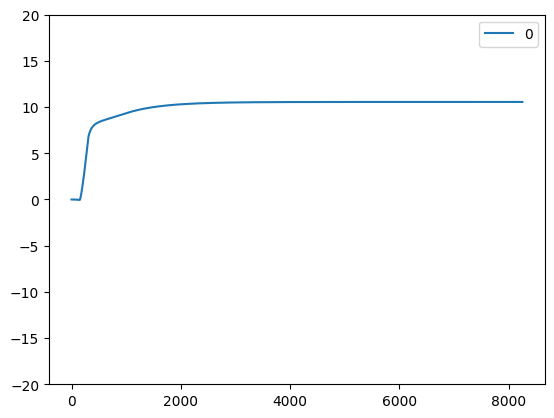

In [23]:
df_temp.dT_glob.plot()
plt.ylim(-20, 20)

<Axes: >

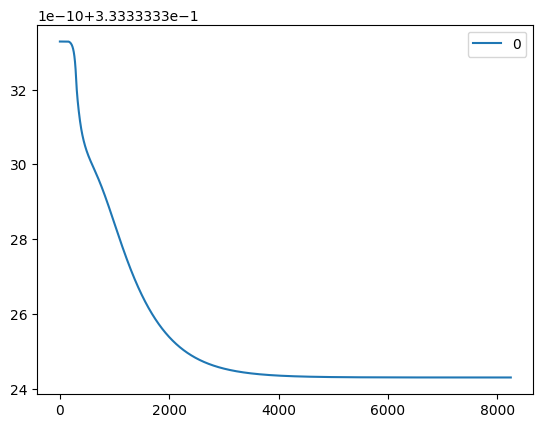

In [24]:
df_temp.wcfac_n.plot(label="Northern Hemisphere")


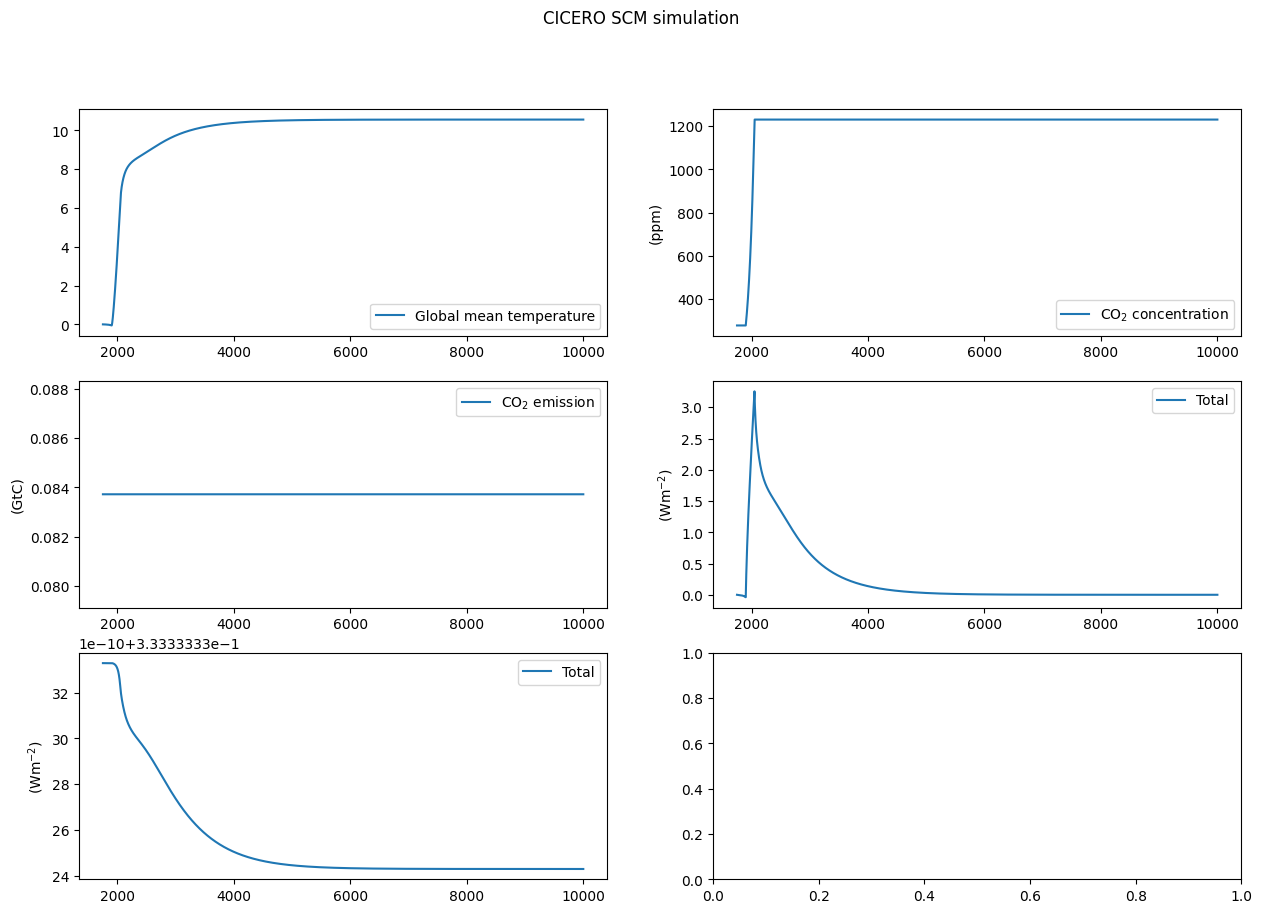

In [25]:
# NBVAL_IGNORE_OUTPUT
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axs = axs.flatten()
fig.suptitle("CICERO SCM simulation")


axs[0].plot(1750 + np.arange(len(df_temp["dT_glob"])), df_temp["dT_glob"])
axs[0].legend(["Global mean temperature", "NH temperature", "SH temperature"])

axs[1].plot(np.arange(len(df_temp["dT_glob"])), df_temp["concentrations"]["CO2"])
axs[1].set_ylabel("(ppm)")
axs[1].legend([r"CO$_2$ concentration"])

axs[2].plot(np.arange(len(df_temp["dT_glob"])), df_temp["emissions"]["CO2"])
axs[2].set_ylabel("(GtC)")
axs[2].legend([r"CO$_2$ emission"])

axs[3].plot(1750 + np.arange(len(df_temp["RIB_glob"])), df_temp["RIB_glob"])
axs[3].set_ylabel("(Wm$^{-2}$)")
axs[3].legend([r"Total"])

axs[4].plot(1750 + np.arange(len(df_temp["RIB_glob"])), df_temp["wcfac_n"])
axs[4].set_ylabel("(Wm$^{-2}$)")
axs[4].legend([r"Total"])



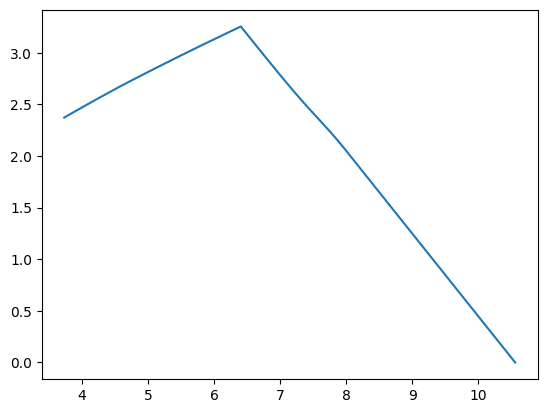

In [26]:
plt.plot(df_temp["dT_glob"][250:],df_temp["RIB_glob"][250:])

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from ciceroscm.upwelling_diffusion_model import UpwellingDiffusionModel

pamset_udm={
    "threstemp": 7.0,  # scales vertical velocity as a function of mixed layer temperature
    "rlamdo": 16.0,  # air-sea heat exchange coefficient (wm^-2K^-1)
    "akapa": 0.634,  # vertical heat diffusivity
    "cpi": 0.4,  # temperature change ratio: polar to nonpolar region
    "W": 4,  # vertical velocity (m/yr)
    "beto": 3.5,  # ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
    "lambda": 3.74 / 3,
    "mixed": 60.0,  # mixed layer depth
    "foan": 0.61,  # fraction of northern hemisphere covered by ocean
    "foas": 0.81,  # fraction of northern hemisphere covered by ocean
    "ebbeta": 0.0,  # atmospheric interhemispheric heat exchange
    "fnso": 0.7531,  # ocean area ratio, northern to southern hemisphere
    "lm": 40,  # number of vertical layers
    "ldtime": 12,
    "dz_vector": dz_list,  # layer thicknesses in meters
    "ocean_efficacy": 1.0,  # Ocean efficacy factor
   }
pamset_emiconc={
    "lamb": 0.8,
    "qbmb": 0.03,
    "qo3": 0.4,
    "qdirso2": -0.457,
    "qindso2": -0.514,
    "qbc": 0.2,
    "qh2o_ch4": 0.171,
    "qoc": -0.103,
    "ref_yr": 2010,
    "idtm": 24,
        # Box carbon cycle model parameters
    "permafrost_initial_carbon": 500.0,         # PgC
    "permafrost_temp_sensitivity": 0.05,        # PgC/K
    "permafrost_release_delay": 50.0,           # years
    "ocean_exchange_rate": 0.01,                # 1/yr
    "ocean_mixed_layer_depth": 25.0,            # m
    "ocean_solubility_base": 0.02,              # arbitrary units
    "ocean_solubility_temp_coeff": -0.01,       # 1/K
    "vegetation_to_soil_fraction": 0.1,         # fraction/yr
    "soil_respiration_rate": 0.02,              # 1/yr
    "beta_f": 0.287,                            # NPP CO2 fertilization factor
    "land_temp_sensitivity": 0.1,               # NPP temperature sensitivity

    # Initial pool sizes (can be adjusted)
    "initial_atmospheric_co2": 278.0,           # ppm
    "initial_vegetation_carbon": 600.0,         # PgC
    "initial_soil_carbon": 3000.0,              # PgC
    "initial_ocean_mixed_layer_carbon": 0.0,    # PgC anomaly
    "initial_ocean_deep_carbon": 0.0,           # PgC anomaly
}
efficacy_values = np.arange(0.8, 1.2, 0.1)
dtemp_results = []
drad_results = []
for eff in efficacy_values:
    pamset_udm["ocean_efficacy"] = eff
    cscm_dir._run(
    {"results_as_dict": True},
        pamset_udm=pamset_udm,
        pamset_emiconc=pamset_emiconc,
    )
    df_temp = to_df(cscm_dir)
    result = df_temp["dT_glob"]
    dtemp_results.append(result)
    drad_results.append(df_temp["RIB_glob"])


/var/folders/pd/218my53900s1gy0k6lcyvjxm0000gn/T/ipykernel_2168/2472678141.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


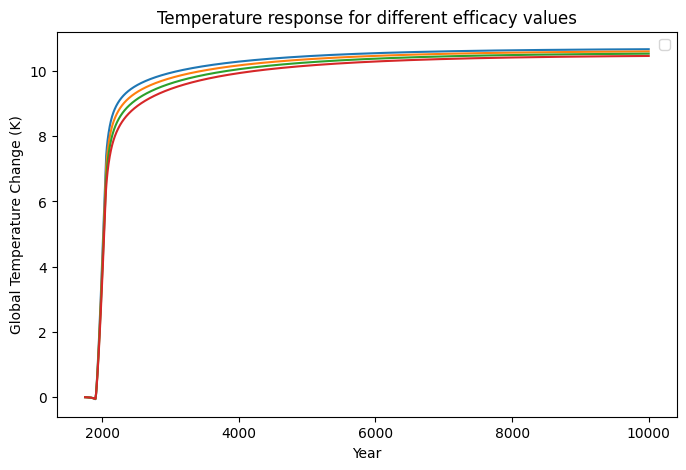

In [28]:

plt.figure(figsize=(8,5))
for i, eff in enumerate(efficacy_values):
    plt.plot(1750 + np.arange(len(df_temp["dT_glob"])), dtemp_results[i])
plt.xlabel("Year")
plt.ylabel("Global Temperature Change (K)")
plt.title("Temperature response for different efficacy values")
plt.legend()
plt.show()

In [29]:
for i in range(39, 40):
    print(i)

39


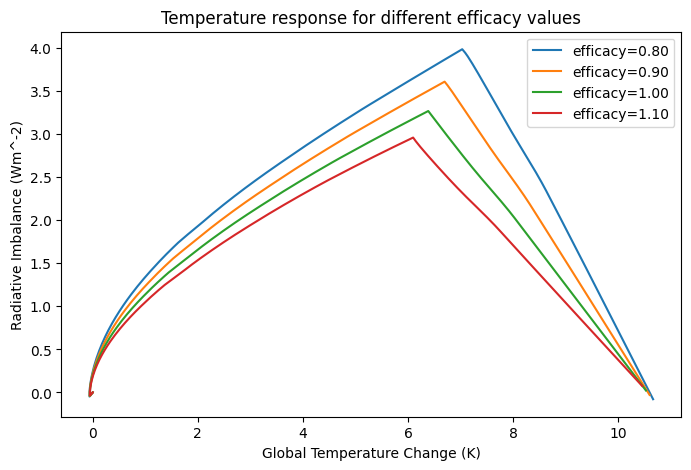

In [30]:

plt.figure(figsize=(8,5))
for i, eff in enumerate(efficacy_values):
    plt.plot(dtemp_results[i],drad_results[i], label=f"efficacy={eff:.2f}")
plt.ylabel("Radiative Imbalance (Wm^-2)")
plt.xlabel("Global Temperature Change (K)")
plt.title("Temperature response for different efficacy values")
plt.legend()
plt.show()


<Axes: >

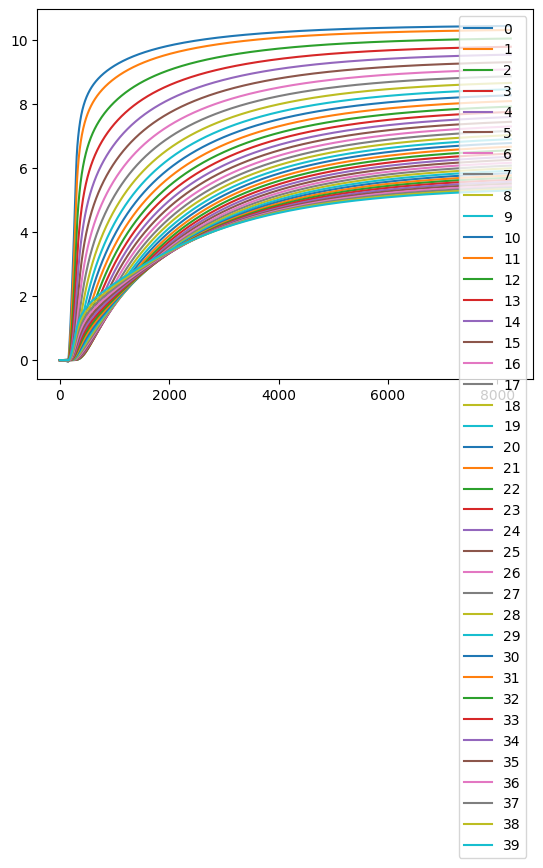

In [31]:
df_temp.tn.plot()



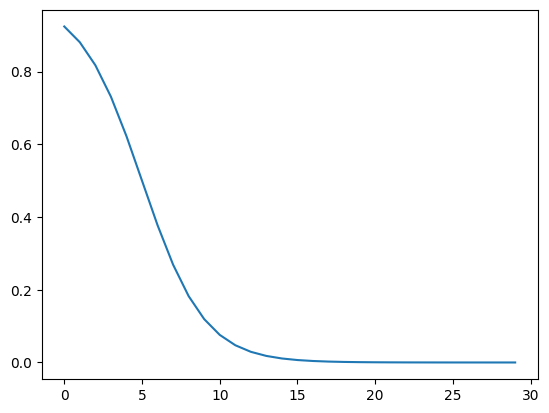

In [32]:
threstemp =5
amoc_sigmoid_width = 2.0
temp_1n=np.arange(0, 30, 1)
factor = 1.0 / (
                    1.0 + np.exp((temp_1n - threstemp) / amoc_sigmoid_width)
                )
plt.plot(temp_1n, factor)